# Pneumonia Detection
The purpose of this project is to design a machine learning model to be able to detect pneumonia in chest x-ray images, as well as distinguish between two pneumonia types (bacterial and viral). This will be done with two different approaces. The first combines two model, one that classifies between healthy and pneumonia images and then if this model predicts pneumonia it will be run through a second model that classifies between viral and bacterial pneumonia. The second approach we use is to train a model that classifies between three classes directly.

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, fbeta_score
import random
import zipfile as zf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Unzipping the data

In [10]:
import zipfile as zf
files = zf.ZipFile("/content/drive/MyDrive/ProjectData/chest_xray.zip", 'r')
files.extractall('ProjectData')
files.close()

# Creating the dataset
Splits the data into 3 datasets, trainData, validationData and testData as dictionaries. These dictionaries contain

- image: image as PIL image

- label: 0-normal, 1-bacterial, 2-viral

In [11]:
class XRayDataset():
    def __init__(self, path):
        self.trainData = []
        self.validationData = []
        self.testData = []

        # Normal train data
        normal_train_path = os.path.join(path, "train/NORMAL")
        for filename in os.listdir(normal_train_path):
            image_path = os.path.join(normal_train_path, filename)
            if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                image = Image.open(image_path)
                image = cropToSquare(image)
                image = transforms.functional.invert(image)
                self.trainData.append({"image":image, "label": torch.tensor(0).long()})

        # Pneumonia train data
        pneumonia_train_path = os.path.join(path, "train/PNEUMONIA")
        for filename in os.listdir(pneumonia_train_path):
            image_path = os.path.join(pneumonia_train_path, filename)
            if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                image = Image.open(image_path)
                image = cropToSquare(image)
                image = transforms.functional.invert(image)
                if "bacteria" in str(filename):
                    self.trainData.append({"image":image, "label": torch.tensor(1).long()})
                else:
                    self.trainData.append({"image":image, "label": torch.tensor(2).long()})

        #Validation set load
        normal_val_path = os.path.join(path, "val/NORMAL")
        for filename in os.listdir(normal_val_path):
            image_path = os.path.join(normal_val_path, filename)
            if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                image = Image.open(image_path)
                image = cropToSquare(image)
                image = transforms.functional.invert(image)
                self.validationData.append({"image":image, "label": torch.tensor(0).long()})

        pneumonia_val_path = os.path.join(path, "val/PNEUMONIA")
        for filename in os.listdir(pneumonia_val_path):
            image_path = os.path.join(pneumonia_val_path, filename)
            if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                image = Image.open(image_path)
                image = cropToSquare(image)
                image = transforms.functional.invert(image)
                if "bacteria" in str(filename):
                    self.validationData.append({"image":image, "label": torch.tensor(1).long()})
                else:
                    self.validationData.append({"image":image, "label": torch.tensor(2).long()})

        #Testing set load
        normal_test_path = os.path.join(path, "test/NORMAL")
        for filename in os.listdir(normal_test_path):
            image_path = os.path.join(normal_test_path, filename)
            if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                image = Image.open(image_path)
                image = cropToSquare(image)
                image = transforms.functional.invert(image)
                self.testData.append({"image":image, "label": torch.tensor(0).long()})

        pneumonia_test_path = os.path.join(path, "test/PNEUMONIA")
        for filename in os.listdir(pneumonia_test_path):
            image_path = os.path.join(pneumonia_test_path, filename)
            if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                image = Image.open(image_path)
                image = cropToSquare(image)
                image = transforms.functional.invert(image)
                if "bacteria" in str(filename):
                    self.testData.append({"image":image, "label": torch.tensor(1).long()})
                else:
                    self.testData.append({"image":image, "label": torch.tensor(2).long()})

        random.shuffle(self.trainData)
        random.shuffle(self.testData)

        n = len(self.trainData)
        trainEnd = int(0.85 * n)

        # Split the list
        self.validationData += self.trainData[trainEnd:]
        self.trainData = self.trainData[:trainEnd]

    def get_pneumonia(self):
        # Remove non-pneumonia
        new_train = [d for d in self.trainData if d.get('label') != 0]
        new_val = [d for d in self.validationData if d.get('label') != 0]
        new_test = [d for d in self.testData if d.get('label') != 0]
        return new_train, new_val, new_test

    def checkDistribution(self):
        # Training
        bacteria = 0
        virus = 0
        normal = 0
        for i in self.trainData:
            if i["label"] == 0:
                normal += 1
            elif i["label"] == 1:
                bacteria += 1
            else:
                virus += 1
        print("Normal in training: ", normal)
        print("Bacteria in training: ", bacteria)
        print("Virus in training: ", virus)

        # Validation
        bacteria = 0
        virus = 0
        normal = 0
        for i in self.validationData:
            if i["label"] == 0:
                normal += 1
            elif i["label"] == 1:
                bacteria += 1
            else:
                virus += 1
        print("Normal in validation: ", normal)
        print("Bacteria in validation: ", bacteria)
        print("Virus in validation: ", virus)

        # Test
        bacteria = 0
        virus = 0
        normal = 0
        for i in self.testData:
            if i["label"] == 0:
                normal += 1
            elif i["label"] == 1:
                bacteria += 1
            else:
                virus += 1
        print("Normal in test: ", normal)
        print("Bacteria in test: ", bacteria)
        print("Virus in test: ", virus)

    def printOneImage(self):
        # Resized
        print(len(self.trainData))
        plt.imshow(self.trainData[0]["image"], cmap='gray')
        plt.axis('off')

def cropToSquare(Img):
    width, height = Img.size
    min_side = min(width, height)

    left = (width - min_side) // 2
    top = (height - min_side) // 2
    right = left + min_side
    bottom = top + min_side
    return Img.crop((left, top, right, bottom))

# Hyperparameters
image_size = (512, 512) # Resize images

In [12]:
dataset = XRayDataset("ProjectData/chest_xray")

dataset.checkDistribution()

Normal in training:  1126
Bacteria in training:  2142
Virus in training:  1165
Normal in validation:  223
Bacteria in validation:  396
Virus in validation:  180
Normal in test:  234
Bacteria in test:  242
Virus in test:  148


In [13]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(image_size, interpolation = transforms.functional.InterpolationMode.LANCZOS),
    transforms.ToTensor()
])

class CustomImageDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["image"]
        label = self.dataset[idx]["label"]
        return transform(image), label

Creating the dataloaders

In [14]:
batch_size = 16
trainDataLoader = DataLoader(CustomImageDataset(dataset.trainData), batch_size = batch_size, shuffle = True)
valDataLoader = DataLoader(CustomImageDataset(dataset.validationData), batch_size = batch_size, shuffle = False)
testDataLoader = DataLoader(CustomImageDataset(dataset.testData), batch_size = batch_size, shuffle = False)

# Defining the model
In this project we use a CNN architecture that contains 3 convolutional layers, with pooling layers between, and then two fully-connected layers at the end.

In [15]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Placeholder; will be updated after seeing input shape
        self.fc1 = None
        self.fc2 = nn.Linear(512, num_classes)

    def _initialize_fc(self, x):
        # Run through conv layers to get flattened shape
        with torch.no_grad():  # No need to track gradients for shape inference
            x = self.pool(torch.relu(self.conv1(x)))
            x = self.pool(torch.relu(self.conv2(x)))
            x = self.pool(torch.relu(self.conv3(x)))
            flattened_dim = x.view(x.size(0), -1).shape[1]
            self.fc1 = nn.Linear(flattened_dim, 512).to(x.device)

    def forward(self, x):
        if self.fc1 is None:
            self._initialize_fc(x)

        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 2 + 2 class classification
Traines two models, one to distinguish between pneumonia and non-pneumonia, and one to distinguish between viral and bacterial pneumonia if the first model classifes the sample as pneumonia.

## Healty vs pneumonia
Traines a model to differentiate between pneumonia and non-pneumonia patients, making no differentiatiation between bacterial and viral pneumonia.

In [16]:
print("Training...")
# Initialize model, loss, optimizer
learning_rate = 0.001
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
healthy_vs_pneumonia_model = CNN(2).to(device)
weights = torch.tensor([1.92, 0.68], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(healthy_vs_pneumonia_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,8], gamma=0.1)
bestLoss = float('inf')

for epoch in range(num_epochs):
    healthy_vs_pneumonia_model.train()
    totalLoss = 0
    # Training loop
    for i, (images, labels) in enumerate(trainDataLoader):
        images, labels = images.to(device), labels.to(device)
        labels[labels == 2] = 1 # Combines the two pneumonia classes
        outputs = healthy_vs_pneumonia_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        totalLoss += loss.item()
    scheduler.step()

    # Validation loop
    healthy_vs_pneumonia_model.eval()
    correct, total = 0, 0
    all_predictions, all_labels = [], []
    totalValLoss = 0
    with torch.no_grad():
        for images, labels in valDataLoader:
            images, labels = images.to(device), labels.to(device)
            labels[labels == 2] = 1 # Combines the two pneumonia classes
            outputs = healthy_vs_pneumonia_model(images)
            valLoss = criterion(outputs, labels)
            totalValLoss += valLoss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avgValLoss = totalValLoss/len(valDataLoader)

    if avgValLoss < bestLoss:
        bestLoss = avgValLoss
        torch.save(healthy_vs_pneumonia_model.state_dict(), "ProjectData/HealthyVsPneumoniaModel.pth")
        print(f"New best model saved with val loss {bestLoss:.4f}")

    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    # f2 = fbeta_score(all_labels, all_predictions, average='weighted', beta = 2)
    print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, Train Loss: {totalLoss/len(trainDataLoader):.4f}, Validation Loss: {avgValLoss:.4f}")

Training...
New best model saved with val loss 0.1707
Epoch [1/10], Accuracy: 0.9387, F1-Score: 0.9393, Train Loss: 0.2569, Validation Loss: 0.1707
Epoch [2/10], Accuracy: 0.9374, F1-Score: 0.9379, Train Loss: 0.1323, Validation Loss: 0.1785
New best model saved with val loss 0.1416
Epoch [3/10], Accuracy: 0.9449, F1-Score: 0.9454, Train Loss: 0.1198, Validation Loss: 0.1416
Epoch [4/10], Accuracy: 0.9362, F1-Score: 0.9374, Train Loss: 0.0939, Validation Loss: 0.1606
Epoch [5/10], Accuracy: 0.9537, F1-Score: 0.9538, Train Loss: 0.0725, Validation Loss: 0.1505
Epoch [6/10], Accuracy: 0.9537, F1-Score: 0.9538, Train Loss: 0.0649, Validation Loss: 0.1455
New best model saved with val loss 0.1357
Epoch [7/10], Accuracy: 0.9562, F1-Score: 0.9566, Train Loss: 0.0652, Validation Loss: 0.1357
Epoch [8/10], Accuracy: 0.9524, F1-Score: 0.9524, Train Loss: 0.0602, Validation Loss: 0.1497
Epoch [9/10], Accuracy: 0.9562, F1-Score: 0.9565, Train Loss: 0.0577, Validation Loss: 0.1383
Epoch [10/10], A

## Differentiating between bacterial and viral pneumonia
Creates new datasets by removing the healthy images from the training and validation datasets, and then traines a model to learn the differences between these.

In [17]:
train_data_pneumonia, val_data_pneumonia, test_data_pneumonia = dataset.get_pneumonia()

batch_size = 16
trainDataLoaderPneumonia = DataLoader(CustomImageDataset(train_data_pneumonia), batch_size = batch_size, shuffle = True)
valDataLoaderPneumonia = DataLoader(CustomImageDataset(val_data_pneumonia), batch_size = batch_size, shuffle = False)

In [18]:
print("Training...")
# Initialize model, loss, optimizer
learning_rate = 0.001
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bacterial_vs_viral_model = CNN(2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bacterial_vs_viral_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,8], gamma=0.1)
bestLoss = float('inf')

for epoch in range(num_epochs):
    bacterial_vs_viral_model.train()
    totalLoss = 0
    # Training loop
    for i, (images, labels) in enumerate(trainDataLoaderPneumonia):
        images, labels = images.to(device), labels.to(device)
        labels[labels == 2] = 0 # Changes the label of viral pneumonia since the loss function only accepts [0,num_classes-1]
        outputs = bacterial_vs_viral_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        totalLoss += loss.item()
    scheduler.step()

    # Validation loop
    bacterial_vs_viral_model.eval()
    correct, total = 0, 0
    all_predictions, all_types = [], []
    totalValLoss = 0
    with torch.no_grad():
        for images, labels in valDataLoaderPneumonia:
            images, labels = images.to(device), labels.to(device)
            labels[labels == 2] = 0
            outputs = bacterial_vs_viral_model(images)
            valLoss = criterion(outputs, labels)
            totalValLoss += valLoss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_types.extend(labels.cpu().numpy())

    avgValLoss = totalValLoss/len(valDataLoaderPneumonia)

    if avgValLoss < bestLoss:
        bestLoss = avgValLoss
        torch.save(bacterial_vs_viral_model.state_dict(), "ProjectData/BestBacterialVsViralModel.pth")
        print(f"New best model saved with val loss {bestLoss:.4f}")

    accuracy = accuracy_score(all_types, all_predictions)
    print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}, Train Loss: {totalLoss/len(trainDataLoaderPneumonia):.4f}, Validation Loss: {avgValLoss:.4f}")


Training...
New best model saved with val loss 0.5617
Epoch [1/10], Accuracy: 0.7378, Train Loss: 0.6140, Validation Loss: 0.5617
New best model saved with val loss 0.5514
Epoch [2/10], Accuracy: 0.7378, Train Loss: 0.5767, Validation Loss: 0.5514
Epoch [3/10], Accuracy: 0.7309, Train Loss: 0.5545, Validation Loss: 0.5654
Epoch [4/10], Accuracy: 0.7396, Train Loss: 0.5446, Validation Loss: 0.5559
Epoch [5/10], Accuracy: 0.7378, Train Loss: 0.5220, Validation Loss: 0.5583
Epoch [6/10], Accuracy: 0.7396, Train Loss: 0.5174, Validation Loss: 0.5569
Epoch [7/10], Accuracy: 0.7396, Train Loss: 0.5157, Validation Loss: 0.5515
Epoch [8/10], Accuracy: 0.7413, Train Loss: 0.5154, Validation Loss: 0.5568
Epoch [9/10], Accuracy: 0.7413, Train Loss: 0.5109, Validation Loss: 0.5561
Epoch [10/10], Accuracy: 0.7431, Train Loss: 0.5106, Validation Loss: 0.5564


## Combining the models

In [19]:
# Loadning the best trained models
healthy_vs_pneumonia_model.load_state_dict(torch.load("ProjectData/HealthyVsPneumoniaModel.pth"))
bacterial_vs_viral_model.load_state_dict(torch.load("ProjectData/BestBacterialVsViralModel.pth"))

<All keys matched successfully>

Overall Accuracy: 0.7760
Healthy Correctly Classified: 212
Bacterial/Viral Correctly Classified (among those predicted as pneumonia): 408
Total samples processed: 799
Overall F1-Score: 0.7556


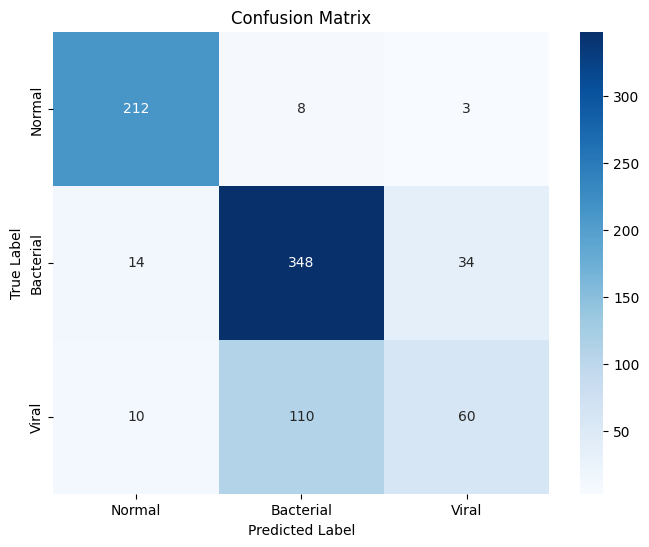

In [20]:
healthy_correct = 0
bacterial_viral_correct = 0
total = 0
all_predictions_combined = [] # List to store predictions for the combined model
all_labels_combined = [] # List to store labels for the combined model

healthy_vs_pneumonia_model.eval()
bacterial_vs_viral_model.eval()
with torch.no_grad():
    for images, labels in valDataLoader:
        images, labels = images.to(device), labels.to(device)

        # Healthy/Pneumonia prediction
        healthy_outputs = healthy_vs_pneumonia_model(images)
        _, healthy_predicted = torch.max(healthy_outputs, 1)

        # Iterate through the batch to potentially run the pneumonia model
        for i in range(images.size(0)):
            # If the first model predicts pneumonia (class 1 in the first model's output)
            if healthy_predicted[i] == 1:
                # Create a mini-batch of size 1 for the pneumonia model
                single_image = images[i].unsqueeze(0) # Add a batch dimension

                # # Adjust label for the pneumonia model (bacteria=1, virus=0)
                # pneumonia_label = labels[i].clone() # Clone to avoid modifying original labels
                # if pneumonia_label == 2:
                #     pneumonia_label = torch.tensor(0, device=labels.device) # Viral becomes 0

                bacterial_viral_output = bacterial_vs_viral_model(single_image)
                _, bacterial_viral_prediction = torch.max(bacterial_viral_output, 1)

                # Map the pneumonia model prediction back to the original label space (1 for bacterial, 2 for viral)
                if bacterial_viral_prediction.item() == 0: # If pneumonia model predicts 0 (viral)
                    combined_prediction = 2
                else: # If pneumonia model predicts 1 (bacterial)
                    combined_prediction = 1

                # print(bacterial_viral_prediction.item() == pneumonia_label.item())
                # bacterial_viral_correct += (bacterial_viral_prediction.item() == pneumonia_label.item())
                bacterial_viral_correct += (combined_prediction == labels[i].item())
                all_predictions_combined.append(combined_prediction)
                all_labels_combined.append(labels[i].item()) # Append original label
            else:
                # If the first model predicts healthy (class 0)
                combined_prediction = 0
                healthy_correct += (healthy_predicted[i].item() == labels[i].item())
                all_predictions_combined.append(combined_prediction)
                all_labels_combined.append(labels[i].item()) # Append original label

        total += labels.size(0)

# Calculate overall accuracy and other metrics using the combined predictions and original labels
overall_accuracy = accuracy_score(all_labels_combined, all_predictions_combined)
# You can also calculate other metrics like F1-score if needed
overall_f1 = f1_score(all_labels_combined, all_predictions_combined, average='weighted')

print(f"Overall Accuracy: {overall_accuracy:.4f}")
# You might want to print accuracies for healthy and pneumonia cases separately for better insight
print(f"Healthy Correctly Classified: {healthy_correct}")
print(f"Bacterial/Viral Correctly Classified (among those predicted as pneumonia): {bacterial_viral_correct}")
print(f"Total samples processed: {total}")
print(f"Overall F1-Score: {overall_f1:.4f}")

# Calculate and print the confusion matrix
cm = confusion_matrix(all_labels_combined, all_predictions_combined)
# print("\nConfusion Matrix:")
# print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Bacterial', 'Viral'], yticklabels=['Normal', 'Bacterial', 'Viral'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Predicting three classes at once

In [21]:
print("Training...")
# Initialize model, loss, optimizer
learning_rate = 0.001
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
three_class_model = CNN(3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(three_class_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,8], gamma=0.1)
bestLoss = float('inf')

for epoch in range(num_epochs):
    three_class_model.train()
    totalLoss = 0
    # Training loop
    for i, (images, labels) in enumerate(trainDataLoader):
        images, labels = images.to(device), labels.to(device)
        outputs = three_class_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        totalLoss += loss.item()
    scheduler.step()

    # Validation loop
    three_class_model.eval()
    correct, total = 0, 0
    all_predictions, all_labels = [], []
    totalValLoss = 0
    with torch.no_grad():
        for images, labels in valDataLoader:
            images, labels = images.to(device), labels.to(device)
            outputs = three_class_model(images)
            valLoss = criterion(outputs, labels)
            totalValLoss += valLoss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avgValLoss = totalValLoss/len(valDataLoader)

    if avgValLoss < bestLoss:
        bestLoss = avgValLoss
        torch.save(three_class_model.state_dict(), "ProjectData/ThreeClassPredictionModel.pth")
        print(f"New best model saved with val loss {bestLoss:.4f}")

    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    # f2 = fbeta_score(all_labels, all_predictions, average='weighted', beta = 2)
    print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, Train Loss: {totalLoss/len(trainDataLoader):.4f}, Validation Loss: {avgValLoss:.4f}")

Training...
New best model saved with val loss 0.6187
Epoch [1/10], Accuracy: 0.7071, F1-Score: 0.7083, Train Loss: 0.7070, Validation Loss: 0.6187
New best model saved with val loss 0.5506
Epoch [2/10], Accuracy: 0.7547, F1-Score: 0.7380, Train Loss: 0.5585, Validation Loss: 0.5506
Epoch [3/10], Accuracy: 0.7597, F1-Score: 0.7573, Train Loss: 0.5280, Validation Loss: 0.5604
Epoch [4/10], Accuracy: 0.7710, F1-Score: 0.7499, Train Loss: 0.4952, Validation Loss: 0.5684
New best model saved with val loss 0.5398
Epoch [5/10], Accuracy: 0.7635, F1-Score: 0.7550, Train Loss: 0.4464, Validation Loss: 0.5398
New best model saved with val loss 0.5391
Epoch [6/10], Accuracy: 0.7610, F1-Score: 0.7549, Train Loss: 0.4386, Validation Loss: 0.5391
New best model saved with val loss 0.5325
Epoch [7/10], Accuracy: 0.7735, F1-Score: 0.7622, Train Loss: 0.4386, Validation Loss: 0.5325
Epoch [8/10], Accuracy: 0.7735, F1-Score: 0.7671, Train Loss: 0.4375, Validation Loss: 0.5366
Epoch [9/10], Accuracy: 0.

# Testing the models

The 2 + 2 classifier

Overall Accuracy: 0.7019
Healthy Correctly Classified: 132
Bacterial/Viral Correctly Classified (among those predicted as pneumonia): 306
Total samples processed: 624
Overall F1-Score: 0.6901
Overall F2-Score: 0.6903


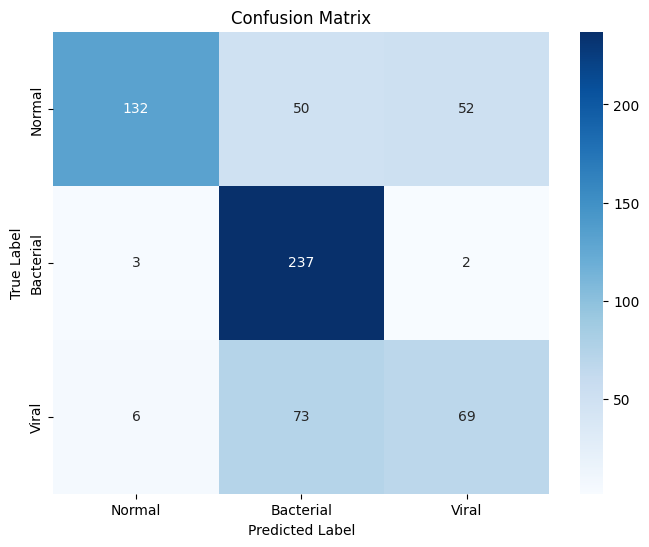

In [22]:
# Loadning the best trained models
healthy_vs_pneumonia_model.load_state_dict(torch.load("ProjectData/HealthyVsPneumoniaModel.pth"))
bacterial_vs_viral_model.load_state_dict(torch.load("ProjectData/BestBacterialVsViralModel.pth"))

healthy_correct = 0
bacterial_viral_correct = 0
total = 0
all_predictions_combined = [] # List to store predictions for the combined model
all_labels_combined = [] # List to store labels for the combined model

healthy_vs_pneumonia_model.eval()
bacterial_vs_viral_model.eval()
with torch.no_grad():
    for images, labels in testDataLoader:
        images, labels = images.to(device), labels.to(device)

        # Healthy/Pneumonia prediction
        healthy_outputs = healthy_vs_pneumonia_model(images)
        _, healthy_predicted = torch.max(healthy_outputs, 1)

        # Iterate through the batch to potentially run the pneumonia model
        for i in range(images.size(0)):
            # If the first model predicts pneumonia (class 1 in the first model's output)
            if healthy_predicted[i] == 1:
                # Create a mini-batch of size 1 for the pneumonia model
                single_image = images[i].unsqueeze(0) # Add a batch dimension

                # # Adjust label for the pneumonia model (bacteria=1, virus=0)
                # pneumonia_label = labels[i].clone() # Clone to avoid modifying original labels
                # if pneumonia_label == 2:
                #     pneumonia_label = torch.tensor(0, device=labels.device) # Viral becomes 0

                bacterial_viral_output = bacterial_vs_viral_model(single_image)
                _, bacterial_viral_prediction = torch.max(bacterial_viral_output, 1)

                # Map the pneumonia model prediction back to the original label space (1 for bacterial, 2 for viral)
                if bacterial_viral_prediction.item() == 0: # If pneumonia model predicts 0 (viral)
                    combined_prediction = 2
                else: # If pneumonia model predicts 1 (bacterial)
                    combined_prediction = 1

                # bacterial_viral_correct += (bacterial_viral_prediction.item() == pneumonia_label.item())
                bacterial_viral_correct += (combined_prediction == labels[i].item())
                all_predictions_combined.append(combined_prediction)
                all_labels_combined.append(labels[i].item()) # Append original label
            else:
                # If the first model predicts healthy (class 0)
                combined_prediction = 0
                healthy_correct += (healthy_predicted[i].item() == labels[i].item())
                all_predictions_combined.append(combined_prediction)
                all_labels_combined.append(labels[i].item()) # Append original label

        total += labels.size(0)

# Calculate overall accuracy and other metrics using the combined predictions and original labels
overall_accuracy = accuracy_score(all_labels_combined, all_predictions_combined)
# You can also calculate other metrics like F1-score if needed
overall_f1 = f1_score(all_labels_combined, all_predictions_combined, average='weighted')
overall_f2 = fbeta_score(all_labels_combined, all_predictions_combined, average='weighted', beta = 2)

print(f"Overall Accuracy: {overall_accuracy:.4f}")
# You might want to print accuracies for healthy and pneumonia cases separately for better insight
print(f"Healthy Correctly Classified: {healthy_correct}")
print(f"Bacterial/Viral Correctly Classified (among those predicted as pneumonia): {bacterial_viral_correct}")
print(f"Total samples processed: {total}")
print(f"Overall F1-Score: {overall_f1:.4f}")
print(f"Overall F2-Score: {overall_f2:.4f}")

# Calculate and print the confusion matrix
cm = confusion_matrix(all_labels_combined, all_predictions_combined)
# print("\nConfusion Matrix:")
# print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Bacterial', 'Viral'], yticklabels=['Normal', 'Bacterial', 'Viral'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Healthy vs Pneumonia

Overall Accuracy: 0.8221
Healthy Correctly Classified: 513
Total samples processed: 624
Overall F1-Score: 0.8095
Overall F2-Score: 0.8126


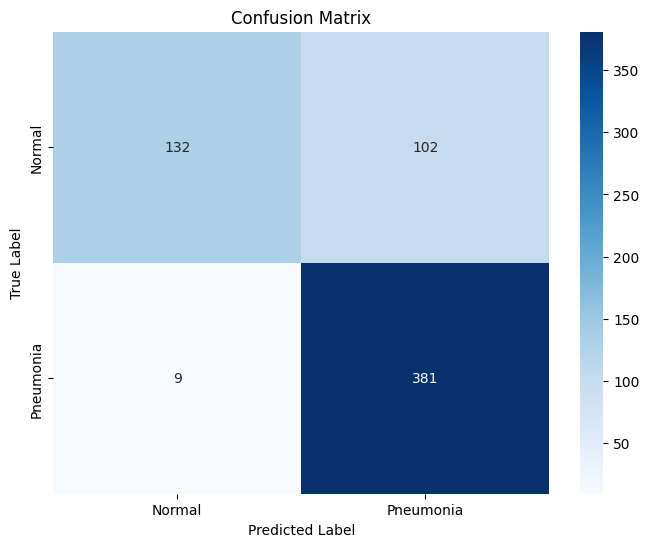

In [23]:
# Loadning the best trained models
healthy_vs_pneumonia_model.load_state_dict(torch.load("ProjectData/HealthyVsPneumoniaModel.pth"))

correct = 0
total = 0
all_predictions_combined = [] # List to store predictions for the combined model
all_labels_combined = [] # List to store labels for the combined model

healthy_vs_pneumonia_model.eval()
with torch.no_grad():
    for images, labels in testDataLoader:
        images, labels = images.to(device), labels.to(device)

        # Prediction
        outputs = healthy_vs_pneumonia_model(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(images.size(0)):
            healthy_label = labels[i].item()
            if healthy_label == 2:
                healthy_label = 1
            correct += (predicted[i].item() == healthy_label)
            all_predictions_combined.append(predicted[i].item()) # Append prediction
            all_labels_combined.append(healthy_label) # Append original label

        total += labels.size(0)

# Calculate overall accuracy and other metrics using the combined predictions and original labels
overall_accuracy = accuracy_score(all_labels_combined, all_predictions_combined)
# You can also calculate other metrics like F1-score if needed
overall_f1 = f1_score(all_labels_combined, all_predictions_combined, average='weighted')
overall_f2 = fbeta_score(all_labels_combined, all_predictions_combined, average='weighted', beta = 2)

print(f"Overall Accuracy: {overall_accuracy:.4f}")
# You might want to print accuracies for healthy and pneumonia cases separately for better insight
print(f"Healthy Correctly Classified: {correct}")
print(f"Total samples processed: {total}")
print(f"Overall F1-Score: {overall_f1:.4f}")
print(f"Overall F2-Score: {overall_f2:.4f}")

# Calculate and print the confusion matrix
cm = confusion_matrix(all_labels_combined, all_predictions_combined)
# print("\nConfusion Matrix:")
# print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


The three-class classifier

Overall Accuracy: 0.6683
Healthy Correctly Classified: 417
Total samples processed: 624
Overall F1-Score: 0.6531
Overall F2-Score: 0.6543


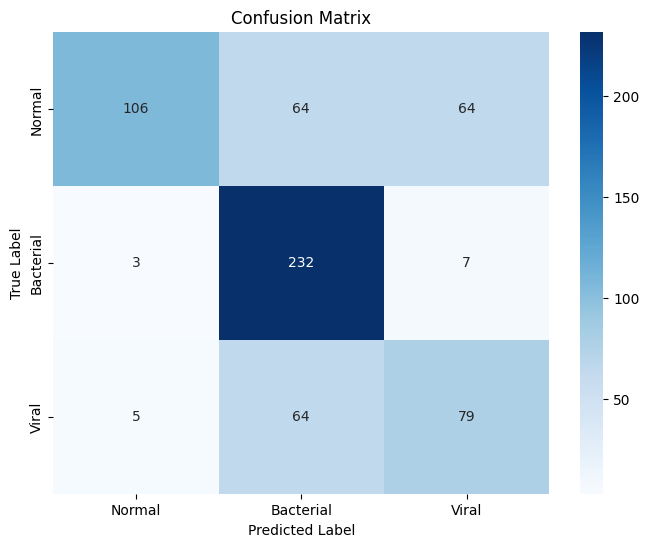

In [24]:
# Loadning the best trained models
three_class_model.load_state_dict(torch.load("ProjectData/ThreeClassPredictionModel.pth", weights_only=True))

correct = 0
total = 0
all_predictions_combined = [] # List to store predictions for the combined model
all_labels_combined = [] # List to store labels for the combined model

three_class_model.eval()
with torch.no_grad():
    for images, labels in testDataLoader:
        images, labels = images.to(device), labels.to(device)

        # Prediction
        outputs = three_class_model(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(images.size(0)):
            correct += (predicted[i].item() == labels[i].item())
            all_predictions_combined.append(predicted[i].item()) # Append prediction
            all_labels_combined.append(labels[i].item()) # Append original label

        total += labels.size(0)

# Calculate overall accuracy and other metrics using the combined predictions and original labels
overall_accuracy = accuracy_score(all_labels_combined, all_predictions_combined)
# You can also calculate other metrics like F1-score if needed
overall_f1 = f1_score(all_labels_combined, all_predictions_combined, average='weighted')
overall_f2 = fbeta_score(all_labels_combined, all_predictions_combined, average='weighted', beta = 2)

print(f"Overall Accuracy: {overall_accuracy:.4f}")
# You might want to print accuracies for healthy and pneumonia cases separately for better insight
print(f"Healthy Correctly Classified: {correct}")
print(f"Total samples processed: {total}")
print(f"Overall F1-Score: {overall_f1:.4f}")
print(f"Overall F2-Score: {overall_f2:.4f}")

# Calculate and print the confusion matrix
cm = confusion_matrix(all_labels_combined, all_predictions_combined)
# print("\nConfusion Matrix:")
# print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Bacterial', 'Viral'], yticklabels=['Normal', 'Bacterial', 'Viral'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Trying different image resizing techniques

<class 'PIL.JpegImagePlugin.JpegImageFile'>


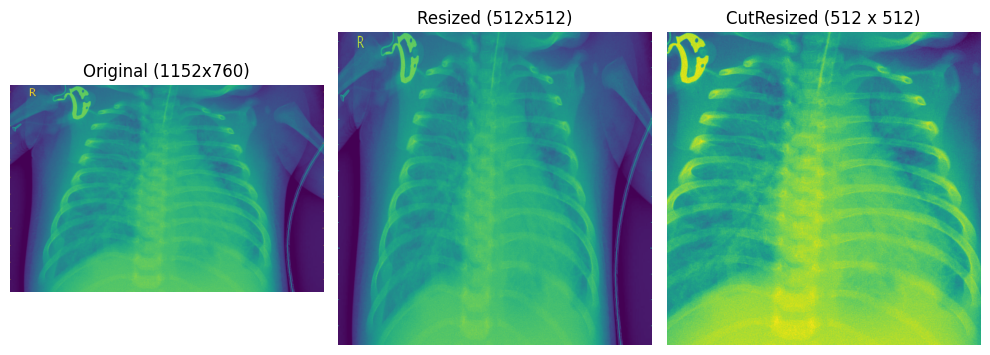

In [26]:
from PIL import Image
import matplotlib.pyplot as pltDetection

# Load the image
image_path = "/content/ProjectData/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg"  # Replace with your image path
original = Image.open(image_path)

print(type(original))
# Resize to 512x512

cutResize = cropToSquare(original)

resized = original.resize((512, 512), Image.LANCZOS)
cutResized = cutResize.resize((512, 512), Image.LANCZOS)

# Plot original and resized image
plt.figure(figsize=(10, 5))

# Original
plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title(f"Original ({original.size[0]}x{original.size[1]})")
plt.axis('off')

# Resized
plt.subplot(1, 3, 2)
plt.imshow(resized)
plt.title("Resized (512x512)")
plt.axis('off')

# CutResized
plt.subplot(1, 3, 3)
plt.imshow(cutResized)
plt.title(f"CutResized ({cutResized.size[0]} x {cutResized.size[1]})")
plt.axis('off')

plt.tight_layout()
plt.show()